In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from io import StringIO
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

Проверить на стационарность ряд цены на нефть (https://finance.yahoo.com/quote/BZ%3DF/history?
period1=1185753600&period2=1666310400&interval=1d&filter=history
&frequency=1d&includeAdjustedClose=true).

In [3]:
ticker = "BZ=F"
start_date = "2007-06-30"
end_date = "2023-10-21"
brent_df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
brent_df.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575


<Axes: xlabel='Date', ylabel='Close'>

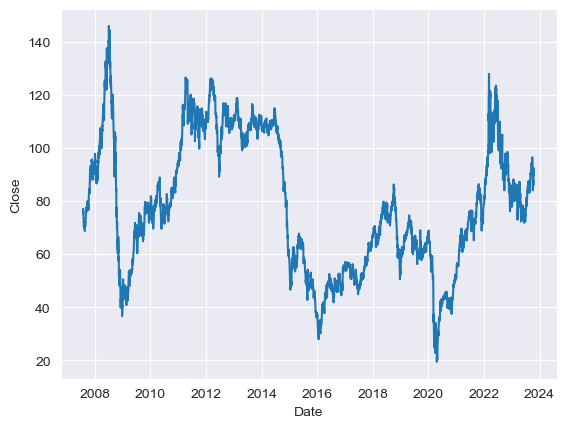

In [5]:
sns.lineplot(data=brent_df, x='Date', y='Close')

- Проводим расширенный тест Дики-Фуллера.
 - Сформируем гипотезы:
    - Нулевая гипотеза (H0) предполагает наличие единичного корня - временной ряд нестационарен.
    - Альтернативная гипотеза (H1) предполагает отсутствие единичного корня - временной ряд стационарен.
- Статистика ADF рассчитывается на основе авторегрессионного уравнения. Если статистика меньше критического значения, нулевая гипотеза отвергается.
- В тесте будет рассчитано p-value. Установим уровень значимости 0.05 и будем отвергать нуль гипотезу при p-value ниже этого уровня.

In [6]:
adf_test = adfuller(brent_df ['Close'])
adf_test

(-2.213616022444665,
 0.20134079354023632,
 15,
 4011,
 {'1%': -3.4319813861701927,
  '5%': -2.862260857164274,
  '10%': -2.5671537198514356},
 15583.025623274)

Мы получили статистику -2.21, что больше критического значения для 5% уровня значимости -2.86. p-value 0.201 > 0.05
Таким образом, не получилось отвергнуть нуль гипотезу на данном уровне значимости, временной ряд нестационарен

Проверить на стационарность ряд из лог-приростов цены на нефть
(https://finance.yahoo.com/quote/BZ%3DF/history?
period1=1185753600&period2=1666310400&interval=1d&filter=history
&frequency=1d&includeAdjustedClose=true).

Гипотеза такая, что преобразование данных в лог-приросты поможет стабилизировать дисперсию и нивелировать зависимость среднего от времени, таким образом получится преобразовать нестационарный ряд в стационарный

In [7]:
brent_df = brent_df.sort_values(by='Date', ascending=False)
brent_df['log'] = np.log(brent_df['Close'] / brent_df['Close'].shift(1))
brent_df = brent_df.dropna()
brent_df.head(2)

,Open,High,Low,Close,Adj Close,Volume,log
Date,,,,,,,
2023-10-19,91.339996,93.470001,89.529999,92.379997,92.379997,34880,0.002384
2023-10-18,90.900002,92.970001,90.599998,91.500000,91.500000,35456,-0.009572


<Axes: xlabel='Date', ylabel='log'>

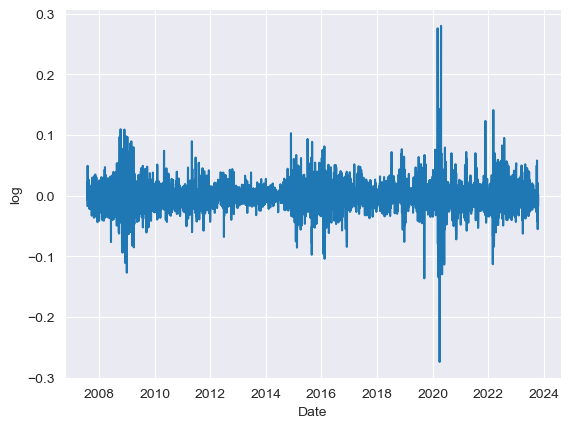

In [8]:
sns.lineplot(data=brent_df, x='Date', y='log')

Визуально можно сказать, что с большей долей вероятности мы получим сильный индикатор стационарности временного ряда

In [9]:
adf_test = adfuller(brent_df ['log'])
adf_test

(-9.386348547221699,
 6.743042698684782e-16,
 29,
 3996,
 {'1%': -3.4319875139327345,
  '5%': -2.862263564080849,
  '10%': -2.567155160899137},
 -18319.795493158006)

Мы получили статистику -9.39, что меньше критического значения для 5% уровня значимости -2.86. p-value близкое к нулю < 0.05 Таким образом, можно отвергнуть нулевую гипотезу на данном уровне значимости и сделать заключение, что ваш временной ряд стационарен .

3. Построить линейную регрессию курса доллара США (https
://finance.yahoo.com/quote/RUB%3DX/history?p=RUB%3DX) к рублю к
цене на нефть и проверить значимость параметров.

In [10]:
usd_rub_df = yf.download('RUB=X', start= start_date, end=end_date)
usd_rub_df.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [11]:
usd_rub_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.0
mean,50.890338,51.299460,50.499369,50.899025,50.899025,0.0
std,20.111665,20.414786,19.774980,20.184631,20.184631,0.0
min,23.167000,23.194000,23.070999,0.716200,0.716200,0.0
25%,30.931600,31.097199,30.785900,30.928850,30.928850,0.0
50%,57.097000,57.459099,56.604000,57.097000,57.097000,0.0
75%,66.080250,66.476597,65.648399,66.055798,66.055798,0.0
max,139.253998,154.714996,134.464996,138.965103,138.965103,0.0


In [12]:
usd_rub_df= usd_rub_df[usd_rub_df['Close'] >= usd_rub_df['Close'].quantile(0.01)]

In [13]:
df = pd.merge(usd_rub_df['Close'], brent_df['Close'], on='Date', how='inner')

In [14]:
df.columns = ['usd_rub','brent']
df.head(1)

,usd_rub,brent
Date,,
2007-07-30,25.535999,75.739998


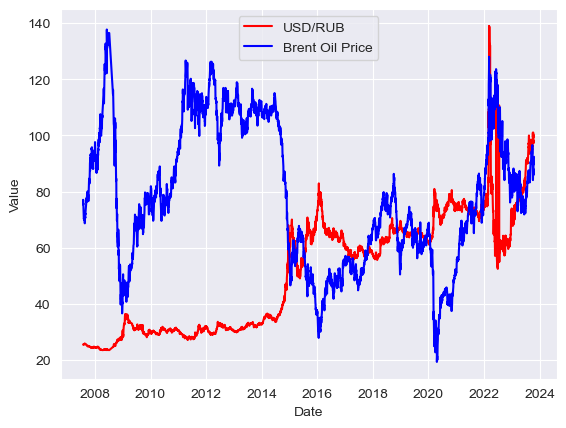

In [15]:
sns.lineplot(data=df, x='Date', y='usd_rub', color='red', label='USD/RUB')
sns.lineplot(data=df, x='Date', y='brent', color='blue', label='Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
X = df[['brent']]
y = df[['usd_rub']]

model = LinearRegression().fit(X, y)

intercept = model.intercept_
slope = model.coef_[0]

print(f'Intercept: {intercept}, Slope: {slope}')


Intercept: [84.16487268], Slope: [-0.4187843]


In [17]:
y_pred = model.predict(X)
r2 = r2_score(y.values, y_pred)
print("R2 score: ", r2)

R2 score:  0.2671284634002422


Плохое значение коэффициента детерминации

In [18]:
diff = y.values - y_pred 

In [19]:
shapiro_test_statistic, shapiro_p_value = stats.shapiro(diff)
shapiro_test_statistic, shapiro_p_value

(0.9550869464874268, 2.9338572081578216e-33)

Посмотрели остатки, тест Шапиро-Уилка показывает, что остатки распределены не в соответствии с нормальным распределением

<Axes: ylabel='Count'>

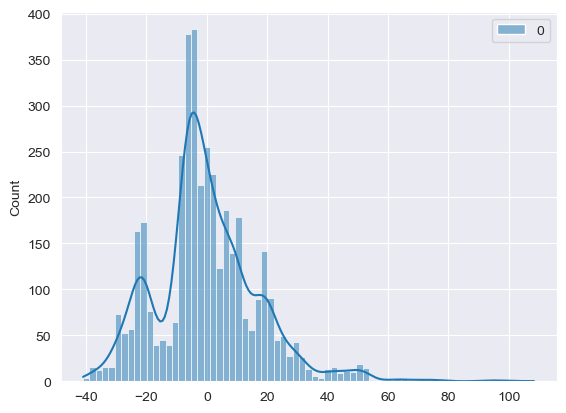

In [20]:
sns.histplot(diff , kde=True)

<Axes: >

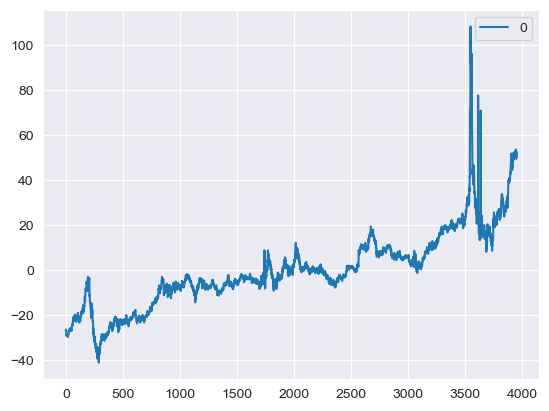

In [21]:
sns.lineplot(diff)

- Остатки имеют тренд, что говорит о плохо специфицированной модели. Предполагалось, что остатки будут колебаться вокруг нуля без какого-либо видимого тренда, который нельзя было увидеть на гистограмме распределения

- Увеличение дисперсии остатков (амплитуды в конце) указывают на гетероскедастичность. Ошибки становятся больше со временем, что говорит о волатильности данных, и внешних факторах, которые не учтены в модели. Значит модель линейной регрессии не совсем подходит. 